# Seoul Bike Sharing Demand Regression Analysis

**Student name:** Rebecca Chu

## Overview

As the demand for an eco-conscious and affordable means of travelling within urban cities increases, the Seoul Metropolitan Government is looking to enhance their e-bike rental marketing strategy and introduce real-time targeting and personalised advertising to encourage e-bike usage. This multiple linear regression analysis aims to identify the conditions that influence the number of bikes rented per hour and provide recommendations for the optimal advertising periods. Using an iterative approach to model-building, the final model found that 8am on weekdays, and 6pm-10pm was associated with an increase in bikes rented. An increase in temperature and decrease in humidity was also associated with an increase in rentals. It is recommended that advertising targets commuters ahead of rush hours and that the campaign focuses on May, June and Autumn months.

## Business Problem

Electric bike sharing systems have seen an exponential rise in popularity in the last 15 years, providing an accessible, eco-friendly and affordable mode of transportation within urban cities. Seoul Public Bike, Ttareungyi, rental system was introduced to ease pressure on traffic congestion, air pollution and the rising oil prices in Seoul, while providing citizens with an opportunity for active mobility. As of January 2023, there are 43,000 Seoul Bikes available for rent.

Seoul Metropolitan Government is looking to enhance their e-bike rental marketing strategy by introducing real-time targeting and personalised advertising. To inform the development of their new campaign, they want to understand the factors that affect rental demand of public e-bikes. This analysis aims to identify the conditions during which bike rental numbers are at their highest and provide recommendations for optimal advertising periods. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import statistics as stats
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

from datetime import time
from itertools import combinations

## Data Understanding

### Seoul Bike Sharing System Rentals

The dataset being explored contains the number of public bicycles rented per hour in the Seoul Public Bike (Ttareungyi) rental system and can be found here https://archive.ics.uci.edu/dataset/560/seoul+bike+sharing+demand. It contains 8,760 hours of data for e-bikes rented from 01-12-2017 to 30-11-2018, including corresponding weather information and whether the day rented was a holiday. The target variable is the number of e-bikes rented per hour. 

Seoul Bike Sharing Demand. (2020). UCI Machine Learning Repository. https://doi.org/10.24432/C5F62R.

In [2]:
sb = pd.read_csv('./data/SeoulBikeData.csv', encoding='latin-1')
sb.head()

,Date,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Seasons,Holiday,Functioning Day
0,01/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,01/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,01/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,01/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,01/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


## Data Preparation

### 1. Data Cleaning

#### 1.1. Renaming Columns and Converting Datatypes

For readability and ease of writing code, I renamed the columns. I also converted `date` into a datetime type so that I could extract the month the bikes were rented.

In [3]:
# transforming column names to all lowercase characters 
sb.columns = map(str.lower, sb.columns)

# renaming appropriate columns for ease of writing code
sb.rename(
    columns={
        'rented bike count': 'bike_count', 
        'temperature(°c)': 'temp', 
        'humidity(%)': 'humidity', 
        'wind speed (m/s)': 'wind_speed_ms', 
        'visibility (10m)': 'visibility_10m',
        'dew point temperature(°c)': 'dew_point_temp',
        'solar radiation (mj/m2)': 'solar_rad',
        'rainfall(mm)': 'rainfall_mm',
        'snowfall (cm)': 'snowfall_cm',
        'functioning day': 'functioning_day',
    }, 
    inplace=True)

In [4]:
sb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8760 non-null   object 
 1   bike_count       8760 non-null   int64  
 2   hour             8760 non-null   int64  
 3   temp             8760 non-null   float64
 4   humidity         8760 non-null   int64  
 5   wind_speed_ms    8760 non-null   float64
 6   visibility_10m   8760 non-null   int64  
 7   dew_point_temp   8760 non-null   float64
 8   solar_rad        8760 non-null   float64
 9   rainfall_mm      8760 non-null   float64
 10  snowfall_cm      8760 non-null   float64
 11  seasons          8760 non-null   object 
 12  holiday          8760 non-null   object 
 13  functioning_day  8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


In [5]:
# converting date to datetime datatype
sb.date = pd.to_datetime(sb.date, format='%d/%m/%Y')

# descriptive statistics for date Series
sb.date.describe()

count                             8760
mean     2018-05-31 23:59:59.999999744
min                2017-12-01 00:00:00
25%                2018-03-02 00:00:00
50%                2018-06-01 00:00:00
75%                2018-08-31 00:00:00
max                2018-11-30 00:00:00
Name: date, dtype: object

#### 1.2. Dropping Irrelevant Rows

In [6]:
sb.functioning_day.value_counts()

functioning_day
Yes    8465
No      295
Name: count, dtype: int64

In [7]:
sb.bike_count.value_counts()

bike_count
0       295
122      19
223      19
262      19
165      18
       ... 
2096      1
2440      1
1600      1
3384      1
595       1
Name: count, Length: 2166, dtype: int64

Taking a look at `functioning_day` we can see that the dataframe includes 295 rows where the rental system was not functioning, which corresponds with the number of rows where `bike_count` was 0.

I decided to drop rows where the rental system was not functioning to avoid skewing the model.

In [8]:
# creating new dataframe with Functioning Days
sb = sb[sb.functioning_day == 'Yes']

#### 1.3. Creating New Features

I created a new column for the month rented to track monthly changes outside of seasons, and a column for the day rented.

In [9]:
# creating a new column for month rented
sb['month'] = sb.date.dt.month

# creating a new column for day rented
sb['day_of_week'] = sb.date.dt.day_name()

I also wanted to explore whether daylight had an impact on the number of bikes rented. Using the Astral package, I created a csv of the dawn and dusk times in Seoul between 01-12-2017 and 30-11-2018 rounded to the nearest hour, which can be found in notebook dawn-dusk-times.ipynb. I chose dawn and dusk times over sunrise and sunset so that I could compare from first light to last light.

In [10]:
sun_info = pd.read_csv('./data/Sun_Info.csv')
sun_info.head()

,Unnamed: 0,dawn,dusk,date
0,0,07:00:00,18:00:00,2017-12-01
1,1,07:00:00,18:00:00,2017-12-02
2,2,07:00:00,18:00:00,2017-12-03
3,3,07:00:00,18:00:00,2017-12-04
4,4,07:00:00,18:00:00,2017-12-05


In [11]:
# dropping the irrelevant column
sun_info.drop('Unnamed: 0', axis=1, inplace=True)

In [12]:
sun_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   dawn    365 non-null    object
 1   dusk    365 non-null    object
 2   date    365 non-null    object
dtypes: object(3)
memory usage: 8.7+ KB


In [13]:
# converting date column to a datatime datatype so that I can merge sun_info to sb
sun_info.date = pd.to_datetime(sun_info.date)

In [14]:
# merging sun_info to sb
sb = sb.merge(sun_info, on='date', how='left')

So that I can calculate whether `hour` sits within the daylight times between dawn and dusk, I converted `dawn` and `dusk` into floats.

In [15]:
# replacing : with . so that I can convert each value into a float
sb.dawn = sb.dawn.map(lambda x: x.replace(':','.')[:5])
sb.dusk = sb.dusk.map(lambda x: x.replace(':','.')[:5])

# converting dawn and dusk into float datatypes
sb.dawn = sb.dawn.astype(float)
sb.dusk = sb.dusk.astype(float)

In [16]:
daylight = []

# creating a list of whether each hour sits within daylight (1) or not (0)
for i, v in enumerate(sb.bike_count):
    if sb.dawn[i] <= sb.hour[i] < sb.dusk[i]:
        daylight.append(1)
    else:
        daylight.append(0)

sb['daylight'] = daylight

I also decided to change `holiday` into a numerical binary, where Holiday = 1 and No Holiday = 0. 

In [17]:
# replacing No Holiday with 0
sb.holiday.replace('No Holiday', 0, inplace=True)
# replacing Holiday with 1
sb.holiday.replace('Holiday', 1, inplace=True)

Finally, I dropped columns that would be irrelevant to my analysis.

In [18]:
# dropping irrelevant columns
sb.drop(['functioning_day', 'dawn', 'dusk'], axis=1, inplace=True)

The final dataset that I will be working with includes the following variables:

* Date
* Rented Bike Count
* Hour
* Temperature (°C)
* Humidity (%)
* Wind Speed (m/s)
* Visibility (10m)
* Dew Point Temperature (°C)
* Solar Radiation (MJ/m2)
* Rainfall (mm)
* Snowfall (cm)
* Season
* Holiday (0 = No Holiday, 1 = Holiday)
* Month
* Day of the Week
* Daylight (0 = Not Daylight, 1 = Daylight)

In [19]:
sb.head()

,date,bike_count,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,0,12,Friday,0
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,0,12,Friday,0
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,0,12,Friday,0


To get a sense of the data I was working with, I grouped by date to see the total number of ebikes rented per day. Our data spans a one-year period; we can see even within this year, it appears as though the bikes rented increases as time progresses. There are two possibilities that may explain this behaviour: 

* e-bikes may see a dramatic decrease in bikes rented in the months of December, January, February and March, which is logical, as these are the Winter months in Korea,
* or e-bike rentals may have increased in popularity as marketing and awareness increased, leading to changes in trends.

Given that we do not have access to information confirming the above and that this data is five years old, I will performing a regression analysis for inference rather than prediction.

Please also note this analysis assumes that the number of Seoul bikes available in this time period has remained the same. 

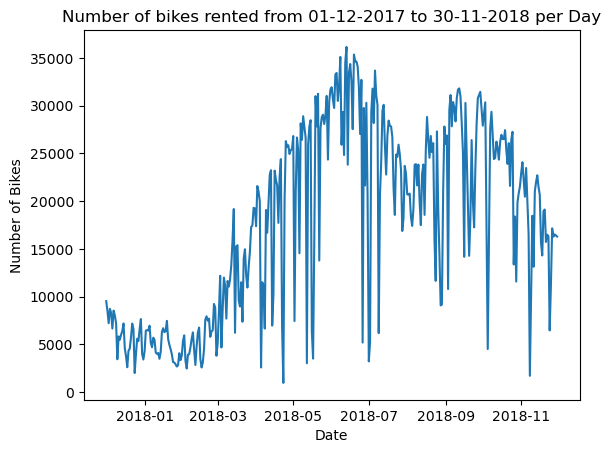

In [20]:
# grouping dataset by date
groupedby_date = sb.groupby(['date']).sum().reset_index()

# plotting the number of bikes rented per day
fig, ax = plt.subplots()
ax.plot(groupedby_date['date'], groupedby_date['bike_count'])
ax.set_title('Number of bikes rented from 01-12-2017 to 30-11-2018 per Day')

plt.xlabel('Date')
plt.ylabel('Number of Bikes');

#### 1.4. Train Test Split

While the primary goal of this analysis is inference, I decided to split the data into train and test to ensure that the predictors that appeared significant in my model would also likely be statistically significant for other observations; we want to ensure that these findings are applicable to the future as that is when the new campaign will commence. I chose to use an 80/20 split.

In [21]:
X = sb.drop('bike_count', axis=1)
y = sb['bike_count']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)

In [22]:
X_train.describe().apply(lambda x: x.apply('{0:.2f}'.format))

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
count,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00,6772.00
mean,.2f,11.49,12.78,58.16,1.74,1425.88,3.95,0.58,0.15,0.08,0.05,6.44,0.55
min,.2f,0.00,-17.50,0.00,0.00,27.00,-30.60,0.00,0.00,0.00,0.00,1.00,0.00
25%,.2f,6.00,3.10,42.00,1.00,920.75,-5.20,0.00,0.00,0.00,0.00,3.00,0.00
50%,.2f,12.00,13.45,57.00,1.50,1669.00,4.70,0.02,0.00,0.00,0.00,6.00,1.00
75%,.2f,17.00,22.70,74.00,2.30,1999.00,15.20,0.95,0.00,0.00,0.00,9.00,1.00
max,.2f,23.00,39.40,98.00,7.40,2000.00,27.20,3.52,35.00,8.80,1.00,12.00,1.00
std,nan,6.89,12.11,20.59,1.04,611.38,13.25,0.88,1.10,0.45,0.22,3.45,0.50


### 2. Exploring the Training Data

#### 2.1. Looking at the Distribution of Variables

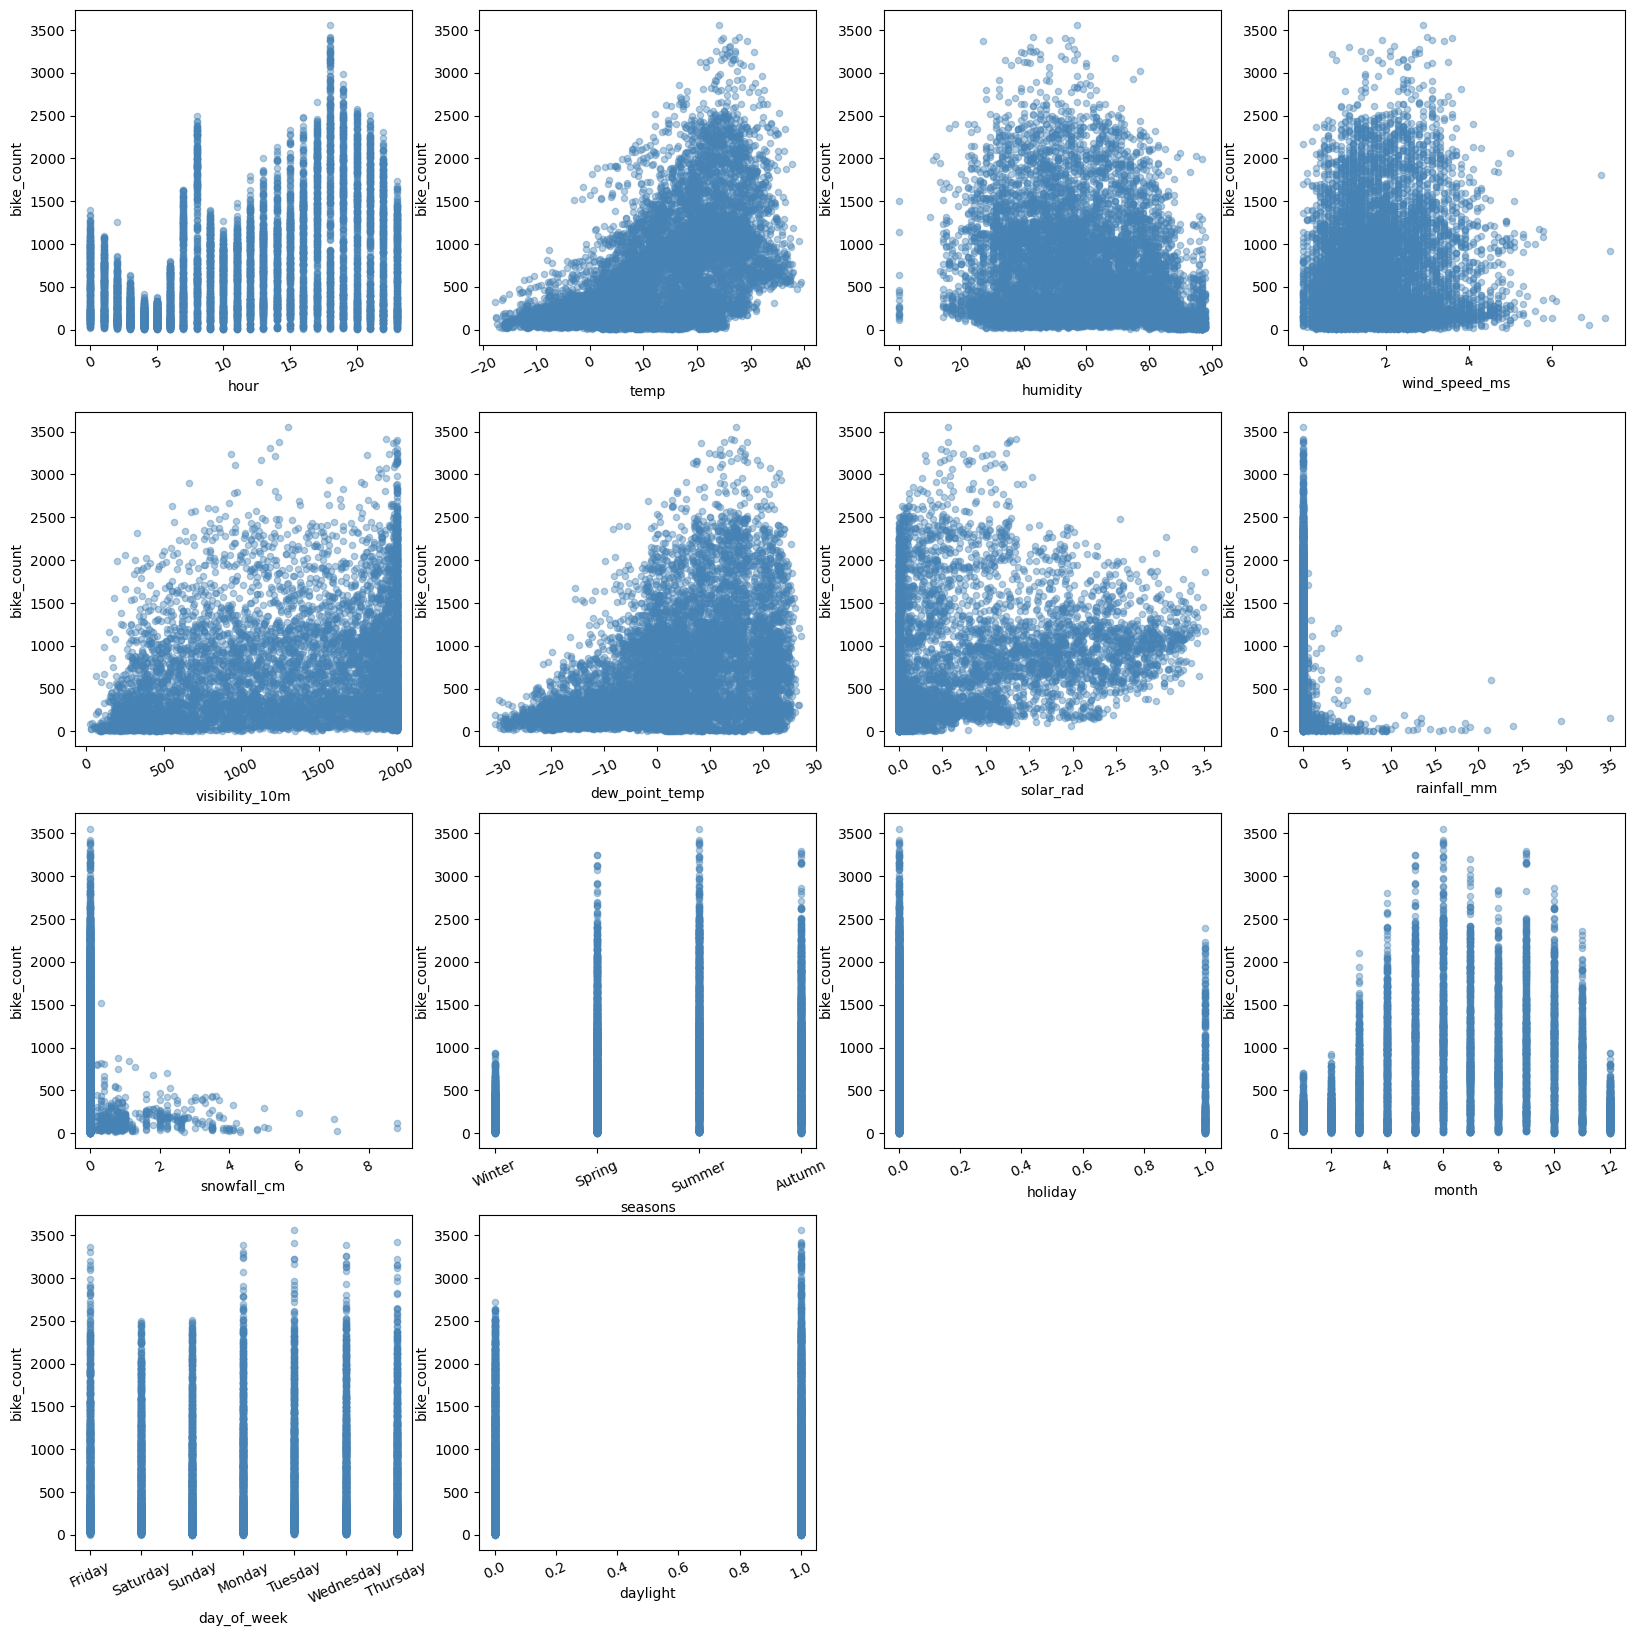

In [23]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(20,20))

# delete empty subplots
for i in range(2,4):
    fig.delaxes(axes[3,i])

predictors = ['hour', 'temp', 'humidity', 'wind_speed_ms', 'visibility_10m', 'dew_point_temp', 
              'solar_rad', 'rainfall_mm', 'snowfall_cm', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight']

for xcol, ax in zip(predictors, axes.flatten()): 
    sb.plot(kind='scatter', x=xcol, y='bike_count', ax=ax, rot=25, alpha=0.4, color='steelblue');

While none of the continuous data have a strong linear relationship with the number of bikes rented, we can see that bike rentals tend to increase with temperature and dew point temperature, while numbers drop as humidity increases. We can also see that a steep drop in the number of bikes rented when there is rainfall or snowfall, however we can also see that for these two variables, data is zero-inflated.

#### 2.2. Account for Multicollinearity

In [24]:
# creating a dataframe with numerical variables (including numerical categoricals)
numerical_data = X_train.drop(['seasons', 'day_of_week'], axis=1)

numerical_data.corr()

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,holiday,month,daylight
date,1.000000,0.006564,0.582448,0.163401,-0.165113,0.105790,0.562816,0.096342,0.035239,-0.137067,-0.079279,0.515380,0.046009
hour,0.006564,1.000000,0.128641,-0.238627,0.292045,0.109612,0.007962,0.150491,0.007564,-0.026597,0.004718,0.003049,0.089974
temp,0.582448,0.128641,1.000000,0.165073,-0.043967,0.023694,0.913370,0.356843,0.052144,-0.216349,-0.059938,0.214861,0.218752
humidity,0.163401,-0.238627,0.165073,1.000000,-0.336094,-0.553389,0.540461,-0.463676,0.244102,0.111642,-0.046124,0.138070,-0.220563
wind_speed_ms,-0.165113,0.292045,-0.043967,-0.336094,1.000000,0.182905,-0.181941,0.326663,-0.018746,0.000390,0.034410,-0.160019,0.207580
visibility_10m,0.105790,0.109612,0.023694,-0.553389,0.182905,1.000000,-0.189854,0.162852,-0.182665,-0.129993,0.029621,0.059907,0.021905
dew_point_temp,0.562816,0.007962,0.913370,0.540461,-0.181941,-0.189854,1.000000,0.096517,0.129696,-0.147828,-0.069451,0.239759,0.082927
solar_rad,0.096342,0.150491,0.356843,-0.463676,0.326663,0.162852,0.096517,1.000000,-0.078697,-0.073852,-0.007763,-0.032262,0.592726
rainfall_mm,0.035239,0.007564,0.052144,0.244102,-0.018746,-0.182665,0.129696,-0.078697,1.000000,0.011176,-0.010901,0.008423,0.024896
snowfall_cm,-0.137067,-0.026597,-0.216349,0.111642,0.000390,-0.129993,-0.147828,-0.073852,0.011176,1.000000,-0.011306,0.061137,-0.005714


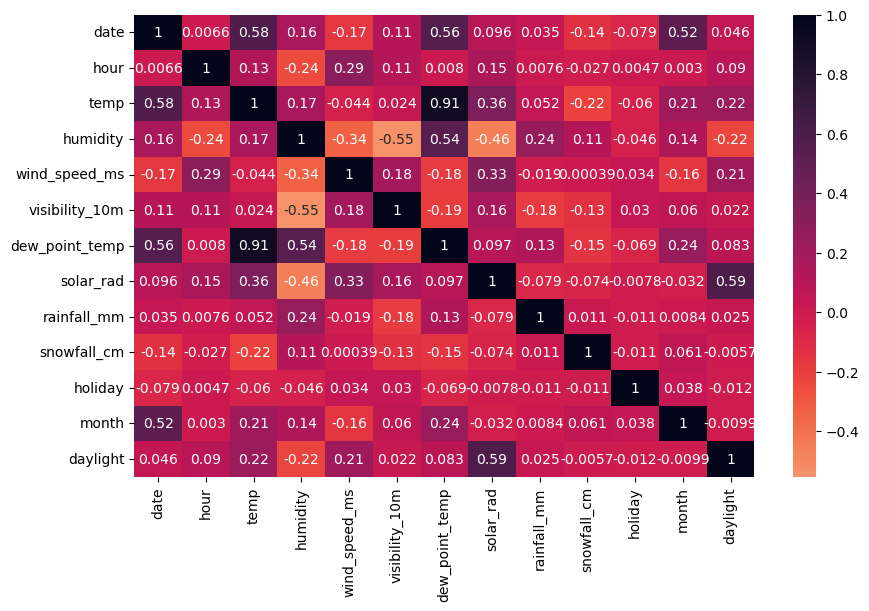

In [25]:
# visualising correlations
fig, ax = plt.subplots(figsize=(10,6))
sns.heatmap(numerical_data.corr(), center=0, annot=True, cmap='rocket_r');

In [26]:
# saving absolute value of the correlation matrix as a data frame
df = numerical_data.corr().abs().stack().reset_index().sort_values(0, ascending=False)

df['pairs'] = list(zip(df.level_0, df.level_1))
df.drop(columns=['level_1','level_0'], inplace=True)
df.set_index(['pairs'], inplace=True)
df.columns = ['cc']

In [27]:
df[(df.cc >.75) & (df.cc<1)]

,cc
pairs,
"(temp, dew_point_temp)",0.91337
"(dew_point_temp, temp)",0.91337


I decided to drop `dew_point_temp` as `temp` is a popular metric for weather forecasts and would most likely be the reference that customers would be using. I also dropped `date` from my `X_train` dataframe as I will not be using it for my models. 

In [28]:
# dropping dew_point_temp and date
X_train.drop(['dew_point_temp', 'date'], axis=1, inplace=True)

## Data Modeling 

### 1. Preparing for Model 1

#### 1.1. Creating Dummy Variables

In [29]:
def create_dummy(cat, df):
    '''
    Function takes a categorical Series and a dataframe and returns dummy variables using get_dummies(). 
    Note that no columns are dropped.
    '''
    return pd.get_dummies(df[f'{cat}'], prefix=f'{cat}', dtype=float)

I decided the drop the following dummy variables: 

* `hour_5`, `seasons_Winter`, `holiday_1` and `month_1` as they appear to see the lowest number of bike rentals according to the earlier scatterplot and acts as an intuitive baseline (we should expect to see only positive coefficients for these categorical coefficients)
* `day_of_week_Monday` as it was the start of the week
* `daylight_0` to see the impact of nighttime

In [30]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
seasons_dummies = create_dummy('seasons', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# removing original columns from dataset
X_train_m1 = X_train.drop(['hour', 'seasons', 'holiday', 'month', 'day_of_week', 'daylight'], 
                                    axis=1)

# concating dummy columns into dataset
X_train_m1 = pd.concat([X_train_m1, hour_dummies, seasons_dummies, holiday_dummies, month_dummies, day_dummies, daylight_dummies], 
                       axis=1)

# removing dropping one column for each categorical
X_train_m1.drop(['hour_5', 'seasons_Winter', 'holiday_1', 'month_1', 'day_of_week_Monday', 'daylight_0', ], axis=1,
                          inplace=True)

X_train_m1.head()

,temp,humidity,wind_speed_ms,visibility_10m,solar_rad,rainfall_mm,snowfall_cm,hour_0,hour_1,hour_2,...,month_10,month_11,month_12,day_of_week_Friday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday,daylight_1
2241,8.8,97,1.3,196,0.20,0.2,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7149,20.1,54,1.2,2000,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
5177,26.6,52,2.2,2000,1.02,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,14.6,54,0.9,431,0.89,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1459,-1.7,91,1.1,167,0.00,0.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Model 1 (Baseline)

I started off by building a baseline model including all predictors, without transforming any continuous variables.

                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.706
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     329.6
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:33:33   Log-Likelihood:                -49228.
No. Observations:                6772   AIC:                         9.856e+04
Df Residuals:                    6722   BIC:                         9.890e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -62.23

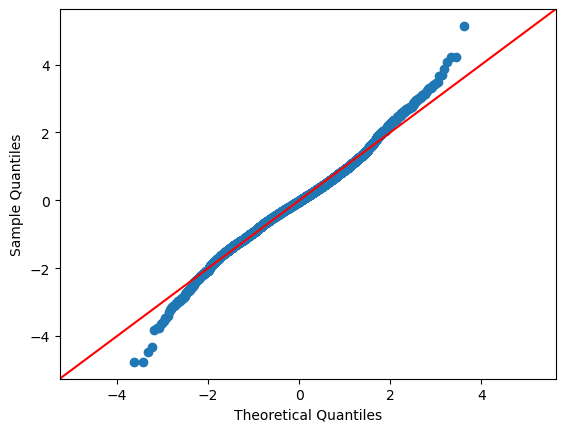

In [31]:
X = X_train_m1
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

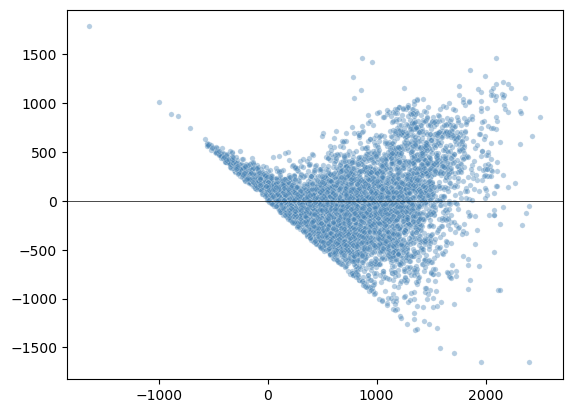

In [32]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [33]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9708854553851026), ('p-value', 0.8032268554834798)]

### Model 1 Observations

My first model yielded a r-squared score of 0.706 and our residuals look approximately normal and does not violate the homoscedasticity assumption. 

We can see that `wind_speed_ms` has a high p-value, so I will be dropping this variable for my second model. Note that the constant also has a high p-value, however as this model is not recommended for prediction I will be leaving it as is.

I decided to also drop `visibility_10m` given its low coefficient. 

Unexpectedly, snowfall yielded a positive coefficient, suggesting that the number of bikes increases as snowfall increases. I decided to explore the snowfall and rainfall variables further to investigate the impact of skewness on results. 

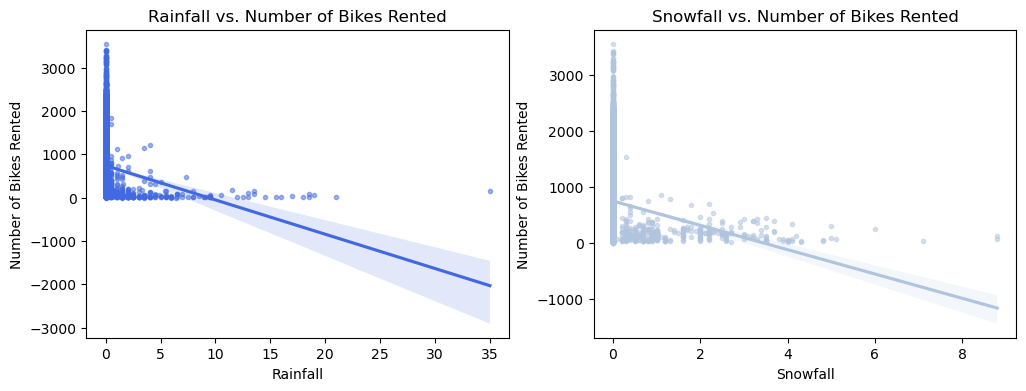

In [34]:
# plotting the linear relationship between rainfall and snowfall with no. of bikes rented
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.regplot(x=X_train.rainfall_mm, y=y_train, color='royalblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[0]
           ).set(title='Rainfall vs. Number of Bikes Rented')
sns.regplot(x=X_train.snowfall_cm, y=y_train, color='lightsteelblue', scatter_kws={'alpha':0.5, 's':9}, ax=axes[1]
           ).set(title='Snowfall vs. Number of Bikes Rented')
axes[0].set_xlabel('Rainfall')
axes[1].set_xlabel('Snowfall')
axes[0].set_ylabel('Number of Bikes Rented')
axes[1].set_ylabel('Number of Bikes Rented');

In [35]:
# looking at the correlation between rainfall and snowfall with the no. of bikes using Pearson's correlation coefficient r
corr_rain_bikes = np.corrcoef(X_train.rainfall_mm, y_train)[0,1] 
print(f'Calculated Pearson Correlation (r) between rain and the number of bikes rented is: \
{"{0:.2f}".format(corr_rain_bikes)}')

corr_snow_bikes = np.corrcoef(X_train.snowfall_cm, y_train)[0,1] 
print(f'Calculated Pearson Correlation (r) between snowfall and the number of bikes rented is: \
{"{0:.2f}".format(corr_snow_bikes)}')

Calculated Pearson Correlation (r) between rain and the number of bikes rented is: -0.14
Calculated Pearson Correlation (r) between snowfall and the number of bikes rented is: -0.15


There appears to be almost no correlation between rainfall or snowfall with the number of bikes rented despite there being a stark drop visually. When I take a look at the distribution of both variables as shown on the box plots below, we can see that both are zero-inflated and all other values are treated as outliers.

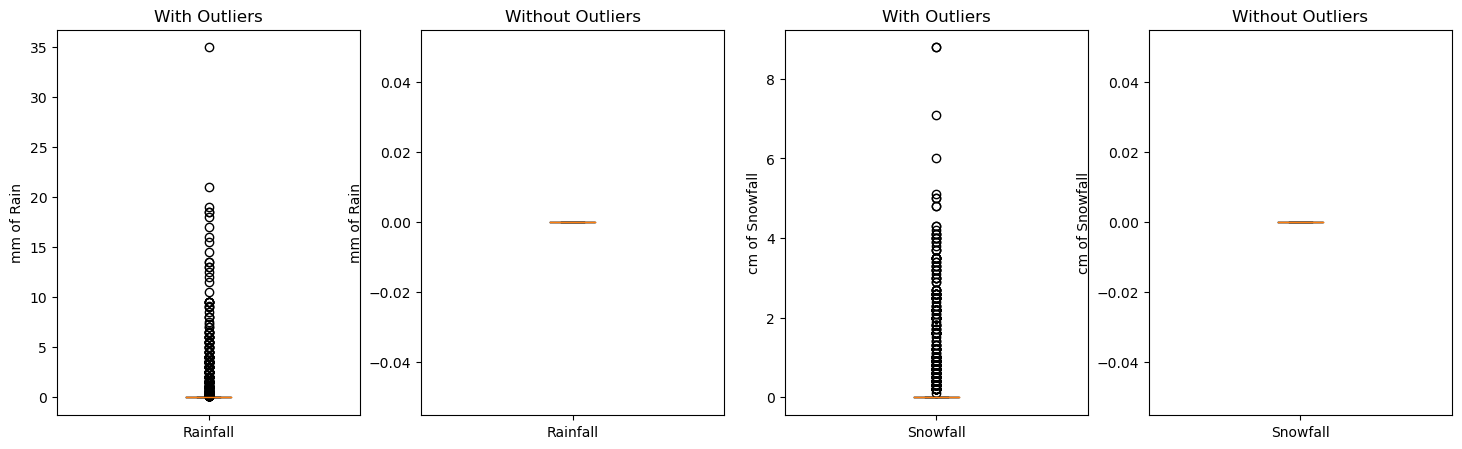

In [36]:
# generating boxplots for rainfall with and without outliers 
fig, axes = plt.subplots(1, 4, figsize=(18,5))

axes[0].boxplot(X_train.rainfall_mm)
axes[1].boxplot(X_train.rainfall_mm, showfliers=False)
axes[2].boxplot(X_train.snowfall_cm)
axes[3].boxplot(X_train.snowfall_cm, showfliers=False)

axes[0].title.set_text('With Outliers')
axes[1].title.set_text('Without Outliers')
axes[0].set_xlabel("Rainfall")
axes[1].set_xlabel("Rainfall")
axes[0].set_ylabel("mm of Rain")
axes[1].set_ylabel("mm of Rain")
axes[0].xaxis.set_tick_params(labelbottom=False)
axes[1].xaxis.set_tick_params(labelbottom=False)

axes[2].title.set_text('With Outliers')
axes[3].title.set_text('Without Outliers')
axes[2].set_xlabel("Snowfall")
axes[3].set_xlabel("Snowfall")
axes[2].set_ylabel("cm of Snowfall")
axes[3].set_ylabel("cm of Snowfall")
axes[2].xaxis.set_tick_params(labelbottom=False)
axes[3].xaxis.set_tick_params(labelbottom=False);

Given that the majority of hours recorded no rainfall or snowfall, hours recording rain or snow act as outliers and there is not enough information to accurately represent the relationship between rainfall/snowfall with the number of bikes rented. In the case of snowfall, since its correlation to the number of bikes is already weak at best, other predictors are most likely supressing snowfall's original relationship resulting in a positive coefficient. 

Another point to consider is that the data only measures the amount of rainfall within the hour, but does not take into consideration the rain's impact on the subsequent hours. For example, depending on the amount of rainfall in the previous hour, roads may be slicker, thus deterring potential riders. Further analysis should be done to assess the impact of rainfall on the hours following. 

For now, I have decided to transform rainfall into a categorical variable, where 0 indicated 0mm of rain and 1 representing any amount of rainfall to negate the effects of a zero-inflated continuous variable. I also decided to drop snowfall from my second model. 

Taking a look at `seasons` vs. `month`, we can see that while Autumn is associated with the highest increase in bikes rented of all the seasons, there is great variability month to month. We can see that June sees the greatest coefficient, however the negative coefficents of July and August are weaking Summer's overall association with rental bikes. I therefore decided to drop `seasons` in favour of `month` for my second model to take into consideration monthly variations.

The baseline model also shows low variation between the coefficients of weekdays, with a notable drop on the weekends. To reduce the number of categories influencing the model, I transformed `days_of_week` into a binary category: weekdays and the weekend.

### 2. Preparing for Model 2

#### 2.1. Feature Scaling Continuous Data

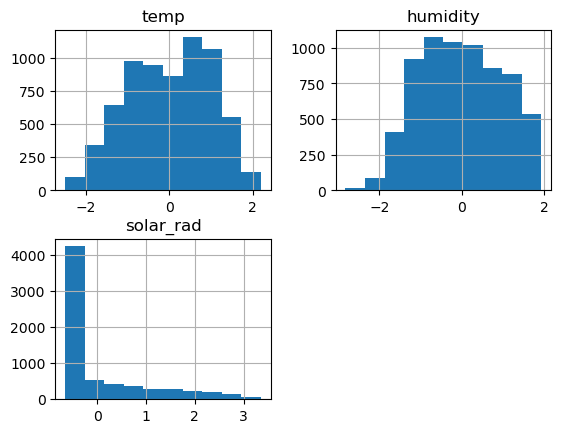

In [37]:
def normalize(feature):
    return (feature - feature.mean())/ feature.std()

cont = ['temp', 'humidity', 'solar_rad']

X_train_m2 = X_train[cont].apply(normalize)

X_train_m2.hist();

#### 2.2. Grouping Categorial Variables

In [38]:
# grouping weekdays and weekends for day_of_week variable 
X_train.day_of_week.replace(dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'weekday'), inplace=True)
X_train.day_of_week.replace(dict.fromkeys(['Saturday','Sunday'], 'weekend'), inplace=True)

In [39]:
# transforming rainfall into a categorical variable
X_train.rainfall_mm = np.where(X_train.rainfall_mm > 0, 1, X_train.rainfall_mm)

In [40]:
X_train.rainfall_mm.value_counts()

rainfall_mm
0.0    6362
1.0     410
Name: count, dtype: int64

#### 2.3. Creating Dummy Variables

In [41]:
# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
rain_dummies = create_dummy('rainfall_mm', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# concating dummy columns into dataset
X_train_m2 = pd.concat([X_train_m2, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m2.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)

X_train_m2.head()

,temp,humidity,solar_rad,hour_0,hour_1,hour_2,hour_3,hour_4,hour_6,hour_7,...,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,day_of_week_weekend,daylight_1
2241,-0.328755,1.886252,-0.434182,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
7149,0.604411,-0.202033,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
5177,1.141188,-0.299162,0.502398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3368,0.150215,-0.202033,0.353916,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
1459,-1.195855,1.594863,-0.662616,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Model 2

Building the second model with the following predictors: `temp`, `humidity`, `solar_rad`, `hour`, `rainfall_mm`, `holiday`, `month`, `day_of_week` and `daylight`.

Continuous variables have been feature scaled and categorical variables grouped together as appropriate.

                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.721
Method:                 Least Squares   F-statistic:                     427.1
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:33:34   Log-Likelihood:                -49035.
No. Observations:                6772   AIC:                         9.815e+04
Df Residuals:                    6730   BIC:                         9.844e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 -39.3556    

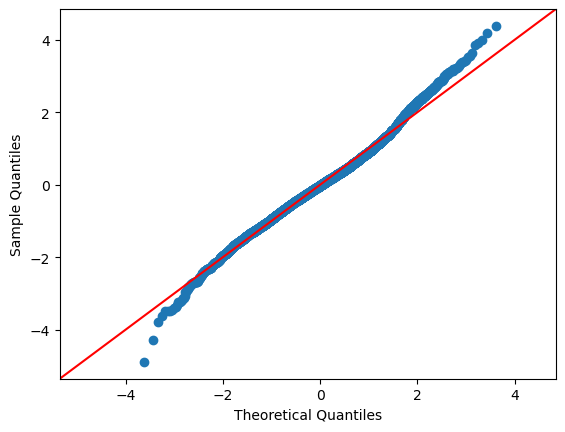

In [42]:
X = X_train_m2
y = y_train

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

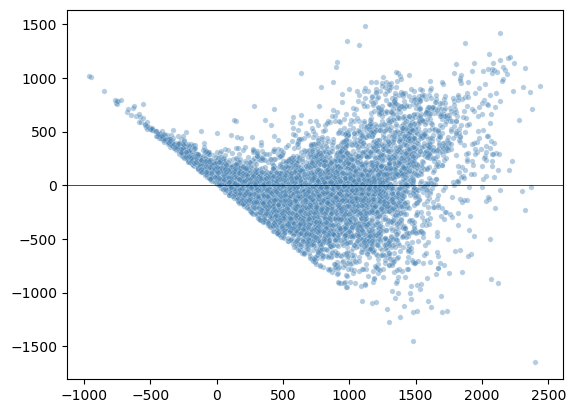

In [43]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [44]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9530149017828059), ('p-value', 0.9179314615859071)]

### Model 2 Observations

R-squared has increased to 0.722, although the p-value for the constant has also increased.

We can see that the number of bikes rented has the strongest associations with `hour`, `rainfall` and `month`: 

* We can see that bike rentals see a strong increase at 8am and between the hours of 6pm and 10pm, which corresponds with Seoul's work hours (9am to 6pm, with many workers also finishing late).
* Rainfall also plays a significant role, dramatically decreasing the number of bikes rented when rainfall is present.
* Bike rentals also vary month to month, in general we see the number of bikes rented increase throughout Spring peaking at the beginning of Summer, and a second peak the middle of Autumn. This supports the positive correlation of temperature with bikes rented, though it appears that the combination of high temperatures and humidity in Summertime may be a deterrent. Seoul has a hot and very humid climate during the Summer months, particularly in July and August, where we do see a drop in bikes rented. From the model, we can also see that humidity also has a negative association with bikes rented.

Given that I have hypothesised a relationship between working hours with the number of bikes rented per hour, I decided to take a look at interactions.

In [45]:
linreg = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
baseline = np.mean(cross_val_score(linreg, X, y, scoring="r2", cv=crossvalidation))

interactions = []

feat_combinations = combinations(X.columns, 2)

data = X.copy()
for i, (a, b) in enumerate(feat_combinations):
    data["interaction"] = data[a] * data[b]
    score = np.mean(
        cross_val_score(linreg, data, y, scoring="r2", cv=crossvalidation)
    )
    if score > baseline:
        interactions.append((a, b, round(score, 3)))

    if i % 50 == 0:
        print(i)

print(
    "Top 5 interactions: %s"
    % sorted(interactions, key=lambda inter: inter[2], reverse=True)[:5]
)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
Top 5 interactions: [('hour_8', 'day_of_week_weekend', 0.732), ('temp', 'hour_18', 0.729), ('temp', 'hour_19', 0.729), ('solar_rad', 'hour_19', 0.728), ('temp', 'hour_20', 0.727)]


As expected, the strongest interaction is between 9am and the weekend, although there is no interaction present between the evening peak and the weekend within the top 5 interactions. Instead, there appears to be an interaction between tempearture and 6pm-8pm. I decided to explore how including the top 3 interactions influenced my model. 

In [46]:
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)
final_m2 = X.copy()

final_m2['hour_8*day_of_week_weekend'] = (final_m2['hour_8'] * final_m2['day_of_week_weekend'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7316050004998138


In [47]:
final_m2['temp*hour_18'] = (final_m2['temp'] * final_m2['hour_18'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7426701467918635


In [48]:
final_m2['temp*hour_19'] = (final_m2['temp'] * final_m2['hour_19'])

final_model_2 = np.mean(cross_val_score(linreg, final_m2, y, scoring="r2", cv=crossvalidation))

print(f'Baseline r2: {baseline}')
print(f'Final Model r2: {final_model_2}')

Baseline r2: 0.7183393256853814
Final Model r2: 0.7572989101632162


We can see that as I included each interaction, my r2 score substantially increases.

                            OLS Regression Results                            
Dep. Variable:             bike_count   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.760
Method:                 Least Squares   F-statistic:                     488.1
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:34:41   Log-Likelihood:                -48521.
No. Observations:                6772   AIC:                         9.713e+04
Df Residuals:                    6727   BIC:                         9.744e+04
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

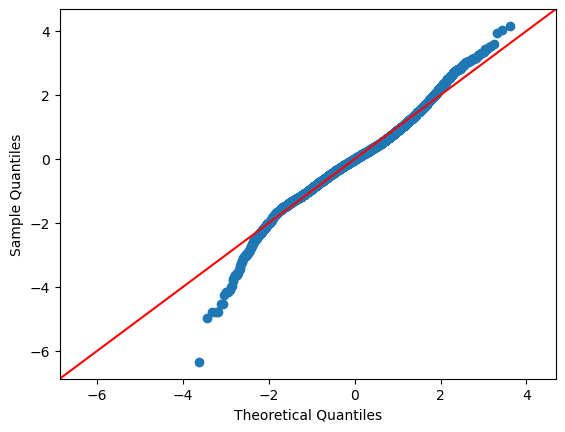

In [49]:
X_int = sm.add_constant(final_m2)
model = sm.OLS(y, X_int).fit()
print(model.summary())

# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

However, taking a look at the qq-plot, we can see that while predictive accuracy increases, normality of residuals suffers. I decided to build my third model including only the strongest interaction.

### Final Model 

My final model includes the following predictors: temperature, humidity, solar radiation, hour, rainfall, whether it was a holiday, whether it was a weekday or a weekend, and daylight. I also accounted for the interaction between `hour_8` and `day_of_week_weekend`.

In [50]:
cont = ['temp', 'humidity', 'solar_rad']

X_train_m3 = X_train[cont].apply(normalize)

# creating dummy variables
hour_dummies = create_dummy('hour', X_train)
rain_dummies = create_dummy('rainfall_mm', X_train)
holiday_dummies = create_dummy('holiday', X_train)
month_dummies = create_dummy('month', X_train)
day_dummies = create_dummy('day_of_week', X_train)
daylight_dummies = create_dummy('daylight', X_train)

# concating dummy columns into dataset
X_train_m3 = pd.concat([X_train_m3, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_train_m3.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)


X_train_m3['hour_8*day_of_week_weekend'] = (X_train_m3['hour_8'] * X_train_m3['day_of_week_weekend'])

In [51]:
X = X_train_m3
y = y_train 

# building the model
X_int = sm.add_constant(X)
model = sm.OLS(y, X_int).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             bike_count   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     446.1
Date:                Tue, 10 Oct 2023   Prob (F-statistic):               0.00
Time:                        17:34:41   Log-Likelihood:                -48868.
No. Observations:                6772   AIC:                         9.782e+04
Df Residuals:                    6729   BIC:                         9.811e+04
Df Model:                          42                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                        -44.4363     36.676     -1.212      0.226    -116.332      27.460
temp                         264.4919     12.731     20.776      0.000     239.536     289.448
humidity                    -106.8469      5.835    -18.311      0.000    -118.285     -95.408
solar_rad                     37.4884      8.572      4.373      0.000      20.684      54.293
hour_0                       390.0442     28.955     13.471      0.000     333.284     446.804
hour_1                       265.9508     28.946      9.188      0.000     209.208     322.694
hour_2                       168.5759     29.028      5.807      0.000     111.672     225.480
hour_3                       102.1746     28.984      3.525      0.000      45.357     158.992
hour_4                        10.1475     28.978      0.350      0.726     -46.659      66.954
hour_6                       156.1236     28.601      5.459      0.000     100.056     212.191
hour_7                       419.3023     31.210     13.435      0.000     358.121     480.484
hour_8                      1051.7571     33.806     31.112      0.000     985.488    1118.027
hour_9                       370.3955     32.145     11.523      0.000     307.381     433.411
hour_10                      145.1350     33.116      4.383      0.000      80.218     210.052
hour_11                      154.0098     34.328      4.486      0.000      86.717     221.303
hour_12                      209.5243     35.435      5.913      0.000     140.061     278.988
hour_13                      207.6346     35.512      5.847      0.000     138.020     277.249
hour_14                      225.3194     35.219      6.398      0.000     156.280     294.359
hour_15                      299.5992     34.499      8.684      0.000     231.970     367.229
hour_16                      407.6745     33.451     12.187      0.000     342.100     473.249
hour_17                      692.2586     32.756     21.134      0.000     628.046     756.471
hour_18                     1179.3032     29.677     39.738      0.000    1121.127    1237.479
hour_19                      910.4515     28.719     31.703      0.000     854.154     966.749
hour_20                      824.9675     30.058     27.446      0.000     766.044     883.891
hour_21                      817.1397     29.298     27.891      0.000     759.706     874.573
hour_22                      730.9405     29.270     24.972      0.000     673.562     788.319
hour_23                      494.1373     28.954     17.066      0.000     437.379     550.896
rainfall_mm_1.0             -537.4652     19.140    -28.080      0.000    -574.986    -499.944
holiday_0                    150.6873     19.112      7.884      0.000     113.221     188.154
month_2                      -43.2887     2

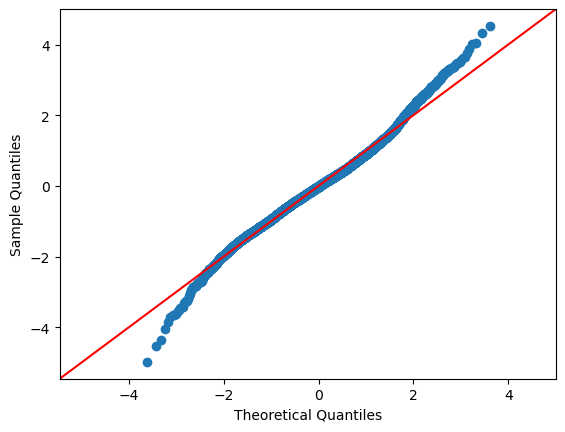

In [52]:
# checking normality assumptions
sm.qqplot(model.resid, line='45', fit=True);

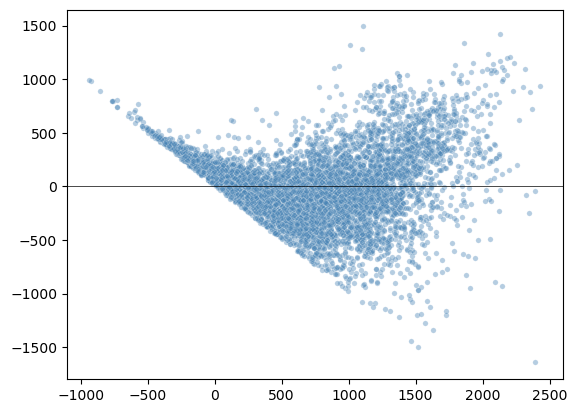

In [53]:
# checking homoscedasticity assumption
pred = model.predict(X_int)
residuals = model.resid

sns.scatterplot(x=pred, y=residuals, s=15, alpha=0.4, color='steelblue')
plt.axhline(y=0, color='black', linewidth=0.5);

In [54]:
name = ['F statistic', 'p-value']
test =  sm.stats.diagnostic.het_goldfeldquandt(model.resid, model.model.exog)
list(zip(name, test))

[('F statistic', 0.9625554507434023), ('p-value', 0.8650230337771144)]

## Evaluation

### Model Validation

While this analysis was intended for inference, we want to ensure that statistically significant predictors can be generalised beyond our training data and used to inform future behaviour.

In [55]:
linreg.fit(X, y)

LinearRegression()

In [56]:
# transforming categories in test data to match train data
X_test.day_of_week.replace(dict.fromkeys(['Monday','Tuesday','Wednesday','Thursday', 'Friday'], 'weekday'), inplace=True)
X_test.day_of_week.replace(dict.fromkeys(['Saturday','Sunday'], 'weekend'), inplace=True)

# transforming rainfall into a categorical variable
X_test.rainfall_mm = np.where(X_test.rainfall_mm > 0, 1, X_test.rainfall_mm)

X_test.head()

,date,hour,temp,humidity,wind_speed_ms,visibility_10m,dew_point_temp,solar_rad,rainfall_mm,snowfall_cm,seasons,holiday,month,day_of_week,daylight
2921,2018-04-01,17,18.0,72,1.8,559,12.8,0.47,0.0,0.0,Spring,0,4,weekend,1
3252,2018-04-16,12,15.5,33,2.5,1893,-0.7,3.10,0.0,0.0,Spring,0,4,weekday,1
3638,2018-05-02,14,17.5,94,0.3,436,16.5,0.35,0.0,0.0,Spring,0,5,weekday,1
5355,2018-07-14,3,25.2,83,1.1,1835,22.0,0.00,0.0,0.0,Summer,0,7,weekend,0
7517,2018-10-19,12,17.4,33,1.1,2000,0.9,2.39,0.0,0.0,Autumn,0,10,weekday,1


In [57]:
# preparing test data for linear regression model
cont = ['temp', 'humidity', 'solar_rad']

X_test_processed = X_test[cont].apply(normalize)

# creating dummy variables
hour_dummies = create_dummy('hour', X_test)
rain_dummies = create_dummy('rainfall_mm', X_test)
holiday_dummies = create_dummy('holiday', X_test)
month_dummies = create_dummy('month', X_test)
day_dummies = create_dummy('day_of_week', X_test)
daylight_dummies = create_dummy('daylight', X_test)

# concating dummy columns into dataset
X_test_processed = pd.concat([X_test_processed, hour_dummies, rain_dummies, holiday_dummies, month_dummies, 
                        day_dummies, daylight_dummies], axis=1)

# removing dropping one column for each categorical
X_test_processed.drop(['hour_5', 'rainfall_mm_0.0', 'holiday_1', 'month_1', 'day_of_week_weekday', 
                 'daylight_0'], axis=1, inplace=True)


X_test_processed['hour_8*day_of_week_weekend'] = (X_test_processed['hour_8'] * X_test_processed['day_of_week_weekend'])

In [58]:
print(f'r2 score of Training data: {linreg.score(X, y)}')

X_test = X_test_processed
y_test = y_test

print(f'r2 score of Test data: {linreg.score(X_test, y_test)}')

r2 score of Training data: 0.7357580554763024
r2 score of Test data: 0.7227096442961216


In [59]:
y_hat_train = linreg.predict(X)
y_hat_test = linreg.predict(X_test_processed)

In [60]:
train_mse = mean_squared_error(y, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squared Error:', train_mse)
print('Test Mean Squared Error:', test_mse)

Train Mean Squared Error: 108487.02635033424
Test Mean Squared Error: 116622.68169831471


The model performs slightly worse on the test data, however the difference between r-squared score and MSE is not too great. 

The final regression formula is as follows:

In [61]:
model.params

const                          -44.436307
temp                           264.491900
humidity                      -106.846881
solar_rad                       37.488423
hour_0                         390.044213
hour_1                         265.950800
hour_2                         168.575942
hour_3                         102.174556
hour_4                          10.147549
hour_6                         156.123594
hour_7                         419.302269
hour_8                        1051.757121
hour_9                         370.395545
hour_10                        145.135017
hour_11                        154.009849
hour_12                        209.524291
hour_13                        207.634552
hour_14                        225.319395
hour_15                        299.599182
hour_16                        407.674520
hour_17                        692.258558
hour_18                       1179.303151
hour_19                        910.451510
hour_20                        824

I am confident that the variables selected for this model would be statistically significant across today's bike rental numbers, however the values of the coefficients may differ greatly.

## Conclusions

This multiple linear regression analysis aimed to identify the factors/conditions that significantly influenced bike rental numbers, to provide recommendations for the optimal advertising periods. 

Based on the final model, I have found and would recommend the following: 

* Rush hours (8am, and 6pm to 10pm) are associated with an increase in rental bikes as this is likely when commuters are heading into and out of work. The 8am increase in particular is seen only on weekdays; the number of bikes rented during this hour significantly drops on the weekend. Given that these hours see the highest coefficients across the entire formula, it may be assumed that a large share of bike users are commuting to work. We can also see that bike rentals tend to increase when it is not a holiday; this further supports the idea that users are riding for transport rather than pleasure or city sight-seeing. I would recommend creating personalised ads for commuters, time-targetting a few hours before work or the end of the work day to encourage a prompt call to action.

    Targeting commuters may also help build a loyal customer base.

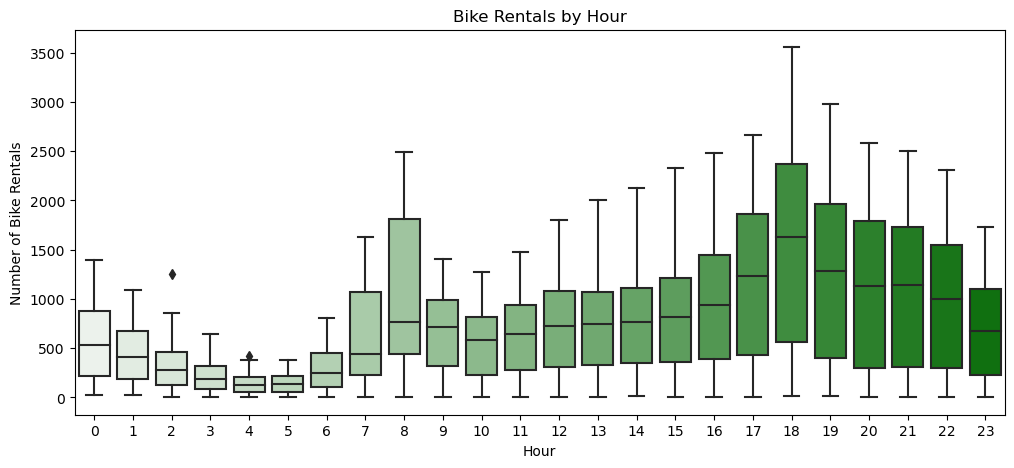

In [62]:
# plotting the relationship between hour and bike rentals
fig, axes = plt.subplots(figsize=(12,5))
sns.boxplot(x=sb.hour, y=sb.bike_count, palette='light:g').set(title='Bike Rentals by Hour')

plt.xlabel('Hour')
plt.ylabel('Number of Bike Rentals');

* Bike rentals tend to increase as the weather warms (as seen in the associated increase in temperature), however decreases when humdity increases. We can visualise this by looking at the monthly data - as we move out of Winter, bike rentals increase and peak at the start of Summer in June, dropping as we head into the hot, humid months of July and August. We then see a second, smaller peak in Autumn where it slowly declines into Winter.

    Summer also experiences the most rainfall of the season, and we can see from our model that rainfall is associated with a significant decrease in bikes rented.

    It would be recommended that marketing campaigns focus on the warmer months, towards the ends of Spring and beginning of Summer, and again in Autumn.

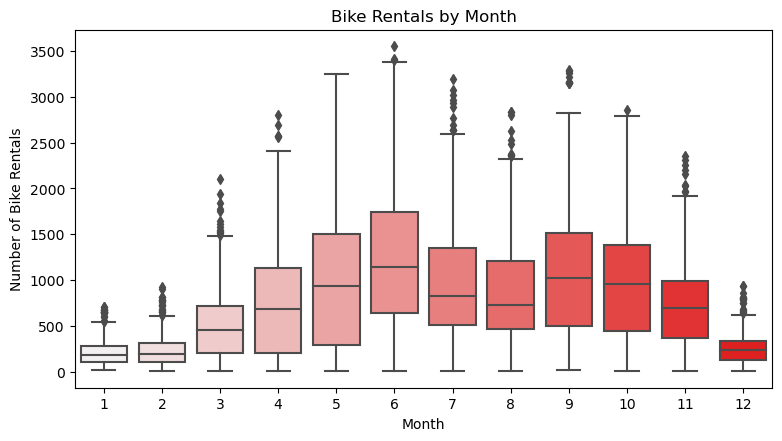

In [63]:
# plotting the relationship between hour and bike rentals
fig, axes = plt.subplots(figsize=(9,4.65))
sns.boxplot(x=sb.month, y=sb.bike_count, palette='light:r').set(title='Bike Rentals by Month')

plt.xlabel('Month')
plt.ylabel('Number of Bike Rentals');

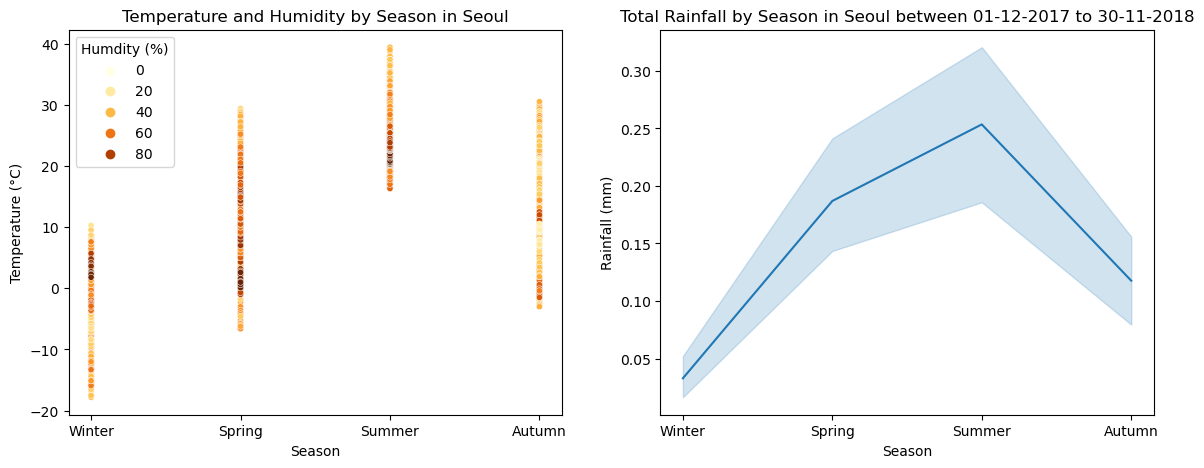

In [64]:
fig, axes = plt.subplots(1,2,figsize=(14,5))
sns.scatterplot(x=sb.seasons, y=sb.temp, hue=sb.humidity, s=20, 
                palette='YlOrBr', ax=axes[0]).set(title='Temperature and Humidity by Season in Seoul')
sns.lineplot(x=sb.seasons, y=sb.rainfall_mm, ax=axes[1]).set(title='Total Rainfall by Season in Seoul between 01-12-2017 to 30-11-2018')

axes[0].set_xlabel('Season')
axes[0].set_ylabel('Temperature (°C)')
axes[0].legend().set_title('Humdity (%)')
axes[1].set_xlabel('Season')
axes[1].set_ylabel('Rainfall (mm)');

* While solar radiation and daylight is associated with an increase in bike rentals, they are not the strongest predictors.

As the model performed similarly on the test data, I am confident that the variables selected would be also be statistically significant beyond the training data, provided that there are no events that may drastically change trends.

**Limitations**

While public bike rental services in Seoul have existed since 2000, Seoul Bike was introduced in 2015, so the system was still relatively new when this data was recorded. Since 2015, Seoul Bike has increased the number of stations and bikes available to rent, naturally resulting in an increase in rentals. Growth in popularity and accessibility for tourists may have resulted in changes to trends. It would be recommended that further analysis is conducted on more recent data across a few years. 

This analysis also does not take into consideration the different passes available in the rental system. Riders can either purchase a one-day or a season pass (with 7-day, 30-day, 180-day and 365-day options). For example, one-day passes may  Categorising these riders may reveal different behaviours amongst distinct customer groups and therefore inform a more personalised advertising approach.